In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import scanpy as sc
sys.path.append("model")
sys.path.append("simulation")
from sc_topology_fast import analyze_array_topology_fast
from Bzinb_EM import BZINB_Model
from univariate_filter import ZINB_Single_Tester
from bivariate_test import fisher_from_bzinb_pis
from simulate import simulate_genes

In [2]:
adata = sc.read_h5ad("sim_data/adata.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 10000 × 72

In [11]:
# tester = ZINB_Single_Tester(min_nonzero=10, min_mean=0.10, cond_thresh=1e6)

# # (A) 检验 H0: phi = phi_true  （理论上应更容易“不拒绝”）
# res_true = tester.fit_and_check(adata.X[:,187], phi_star=(5,0.14,0.5), gene_name="SimGene_trueH0")
model = BZINB_Model()
params, pis = model.fit(adata.X[:,7], adata.X[:,6])
res = fisher_from_bzinb_pis(pis, adata.X.shape[0], alternative="less", round_mode="round")

In [12]:
res

{'pis': array([0.19040503, 0.0028878 , 0.00807416, 0.79863301]),
 'N': 10000,
 'counts_from_pis': {'a': 1904, 'b': 29, 'c': 81, 'd': 7986},
 'table': array([[1904,   29],
        [  81, 7986]]),
 'OR_fisher': 6473.113665389527,
 'p_value': 1.0,
 'alternative': 'less',
 'round_mode': 'round'}

<Axes: >

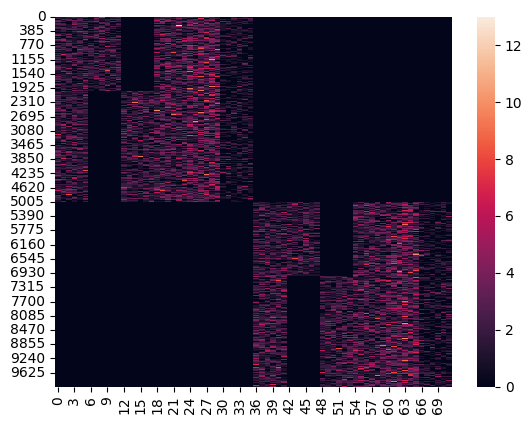

In [4]:
sns.heatmap(adata.X)

In [4]:
adata

AnnData object with n_obs × n_vars = 10000 × 480

In [ ]:
params_, lambda_ = analyze_array_topology_fast(adata.X[:5000,0:240], pair_mode='adjacent_pairs')

In [8]:
params_

{'g0': {'r': 10.657124539560932, 'theta': 0.14225091627228237},
 'g1': {'r': 10.57814094339649, 'theta': 0.14118536176468122}}

In [9]:
import numpy as np
import pandas as pd
from typing import Dict, Any, Tuple


def _to_dense_gene_vector(X, j: int) -> np.ndarray:
    """从 adata.X 中取第 j 列并转成 1D dense int array"""
    col = X[:, j]
    # 兼容 scipy sparse
    if hasattr(col, "toarray"):
        col = col.toarray()
    col = np.asarray(col).reshape(-1)
    # 计数通常是非负整数
    return col.astype(int, copy=False)

def _merge_nb_params(
    nb_params: Dict[str, Dict[str, float]],
    gene_key: str,
    m: float,
    t: float,
    strategy: str = "keep_first"
):
    """
    将单次fit得到的(m,t)写入nb_params（转换成r=1/m, theta=t）
    strategy:
      - keep_first: 如果该gene已存在则不覆盖
      - overwrite: 直接覆盖
      - average_r_theta: 对r,theta做简单平均（不加权）
    """
    m = float(m)
    t = float(t)
    # 基本防护
    m = max(m, 1e-12)
    t = float(np.clip(t, 1e-12, 1 - 1e-12))
    r = 1.0 / m

    if gene_key not in nb_params:
        nb_params[gene_key] = {"r": r, "theta": t}
        return

    if strategy == "keep_first":
        return
    elif strategy == "overwrite":
        nb_params[gene_key] = {"r": r, "theta": t}
    elif strategy == "average_r_theta":
        nb_params[gene_key]["r"] = 0.5 * (nb_params[gene_key]["r"] + r)
        nb_params[gene_key]["theta"] = 0.5 * (nb_params[gene_key]["theta"] + t)
    else:
        raise ValueError(f"Unknown strategy: {strategy}")

def fit_pairs_bzinb_sequential(
    X,
    gene_indices: np.ndarray,
    model_factory,
    nb_strategy: str = "keep_first",
    store_pis: bool = False
) -> Tuple[Dict[str, Any], np.ndarray, np.ndarray, np.ndarray]:

    gene_indices = np.asarray(gene_indices)
    G = len(gene_indices)
    if G < 2:
        raise ValueError("gene_indices length must be >= 2")

    nb_params: Dict[str, Dict[str, float]] = {}
    lam_mat = np.full((G, G), np.nan, dtype=float)
    ok_mat = np.zeros((G, G), dtype=bool)

    pi_tensor = None
    if store_pis:
        pi_tensor = np.full((G, G, 4), np.nan, dtype=float)

    # 预取表达
    Y = [_to_dense_gene_vector(X, int(gi)) for gi in gene_indices]

    # 对角线
    for i in range(G):
        lam_mat[i, i] = 0.0
        ok_mat[i, i] = True
        if store_pis:
            pi_tensor[i, i, :] = np.array([np.nan, np.nan, np.nan, np.nan])

    # 只做 (0,1),(2,3)...
    for i in range(0, G - 1, 2):
        j = i + 1

        y1, y2 = Y[i], Y[j]
        g1_key = f"g{int(gene_indices[i])}"
        g2_key = f"g{int(gene_indices[j])}"

        model = model_factory()

        try:
            params, pis = model.fit(y1, y2)

            lam = float(params["lam"])
            lam_mat[i, j] = lam
            lam_mat[j, i] = lam
            ok_mat[i, j] = True
            ok_mat[j, i] = True

            if store_pis and pi_tensor is not None:
                pi_tensor[i, j, :] = np.asarray(pis, dtype=float)
                pi_tensor[j, i, :] = np.asarray(pis, dtype=float)

            _merge_nb_params(nb_params, g1_key, params["m1"], params["t1"], strategy=nb_strategy)
            _merge_nb_params(nb_params, g2_key, params["m2"], params["t2"], strategy=nb_strategy)

        except Exception:
            lam_mat[i, j] = np.nan
            lam_mat[j, i] = np.nan
            ok_mat[i, j] = False
            ok_mat[j, i] = False
            if store_pis and pi_tensor is not None:
                pi_tensor[i, j, :] = np.nan
                pi_tensor[j, i, :] = np.nan

    return nb_params, lam_mat, pi_tensor, ok_mat



In [10]:
# -------------------------
# 使用示例（你按需替换 gene_indices）
# -------------------------
gene_indices = np.array([i for i in range(240)])  # 举例：你要计算的基因列索引
nb_params, lam_mat, pi_tensor, ok_mat = fit_pairs_bzinb_sequential(
    X=adata.X,
    gene_indices=gene_indices,
    model_factory=lambda: BZINB_Model(),
    nb_strategy="keep_first",
    store_pis=False
)

print(nb_params)           # {'g62': {'r':..., 'theta':...}, ...}
print(lam_mat.shape)       # (G, G)
print(ok_mat.mean())       # 成功率

# 如果你想把 lambda 矩阵带上基因名做成 DataFrame：
gene_names = [f"g{int(i)}" for i in gene_indices]
lam_df = pd.DataFrame(lam_mat, index=gene_names, columns=gene_names)
# print(lam_df.iloc[:5, :5])

KeyboardInterrupt: 

In [8]:
r_dict = {g: d["r"] for g, d in nb_params.items()}
theta_dict = {g: d["theta"] for g, d in nb_params.items()}

r_dict_gd = {g: d["r"] for g, d in params_.items()}
theta_dict_gd = {g: d["theta"] for g, d in params_.items()}

In [9]:
r_esti = list(r_dict.values())
theta_esti = list(theta_dict.values())

r_gd = list(r_dict_gd.values())
theta_gd = list(theta_dict_gd.values())

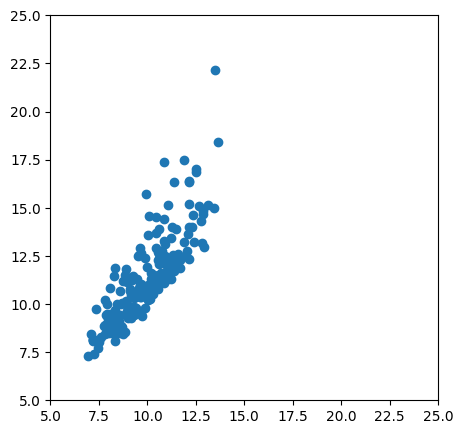

In [10]:
plt.figure(figsize=(5, 5))

plt.scatter(r_gd[0:180],r_esti[0:180])
plt.xlim(5,25)
plt.ylim(5,25)
plt.show()

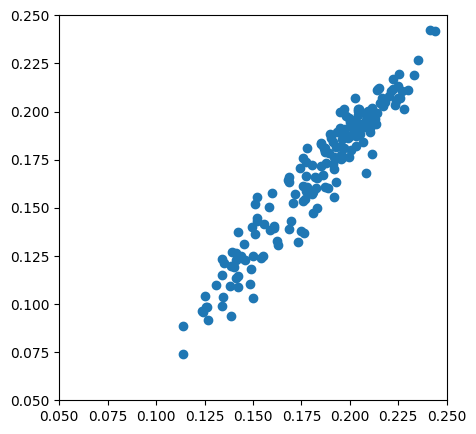

In [11]:
plt.figure(figsize=(5, 5))

plt.scatter(theta_gd[0:180],theta_esti[0:180])
plt.xlim(0.05,0.25)
plt.ylim(0.05,0.25)
plt.show()

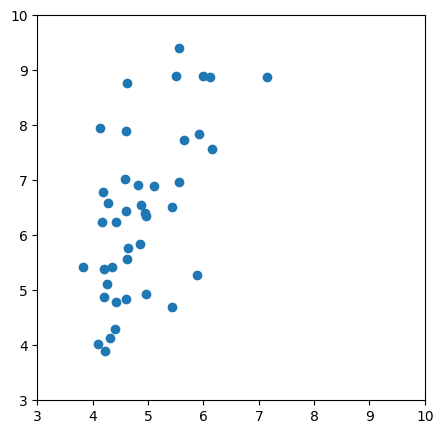

In [13]:
plt.figure(figsize=(5, 5))

plt.scatter(r_gd[180:],r_esti[180:])
plt.xlim(3,10)
plt.ylim(3,10)
plt.show()

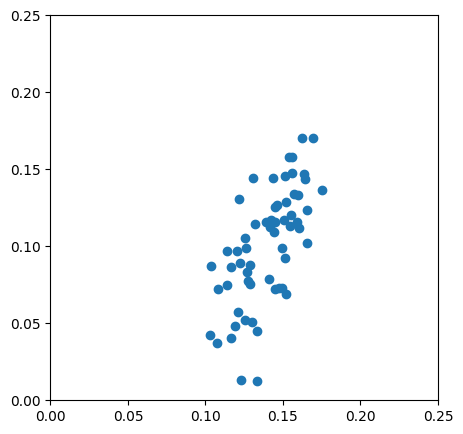

In [15]:
plt.figure(figsize=(5, 5))

plt.scatter(theta_gd[180:],theta_esti[180:])
plt.xlim(0.0,0.25)
plt.ylim(0.0,0.25)
plt.show()

In [16]:
lambda_

,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,...,g230,g231,g232,g233,g234,g235,g236,g237,g238,g239
g0,0.000000,1.793565,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
g1,1.793565,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
g2,0.000000,0.000000,0.000000,1.975807,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
g3,0.000000,0.000000,1.975807,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
g4,0.000000,0.000000,0.000000,0.000000,0.0,1.986968,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
g235,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.029926,0.0,0.000000,0.000000,0.000000,0.000000
g236,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,-0.078765,0.000000,0.000000
g237,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,-0.078765,0.000000,0.000000,0.000000
g238,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,-0.030577


In [17]:
lam_mat = np.nan_to_num(lam_mat, nan=0.0)

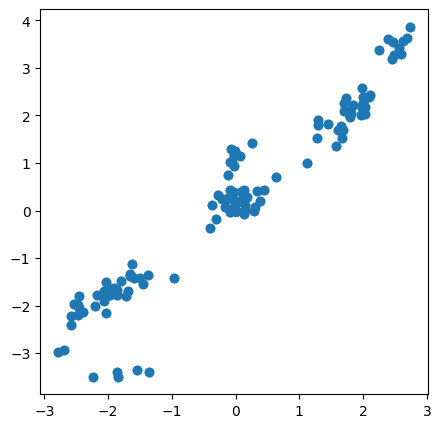

In [18]:
plt.figure(figsize=(5, 5))

plt.scatter(lambda_.values.flatten(),lam_mat.flatten())
# plt.xlim(0.05,0.25)
# plt.ylim(0.05,0.25)
plt.show()

In [ ]:
# ---------------------------
# 示例：共表达/互斥的单侧检验
# ---------------------------
if __name__ == "__main__":
    rng = np.random.default_rng(0)
    # 假设 200 个细胞的二值表达
    A = rng.random(200) < 0.2
    B = rng.random(200) < 0.2

    # 1) 检验共表达倾向：H1: OR > 1
    res_pos = fisher_gene_pair_test(A, B, alternative="greater")
    print("Co-expression (greater):", res_pos)

    # 2) 检验互斥倾向：H1: OR < 1
    res_neg = fisher_gene_pair_test(A, B, alternative="less")
    print("Mutual exclusivity (less):", res_neg)

    # 3) 双侧（不区分方向）
    res_two = fisher_gene_pair_test(A, B, alternative="two-sided")
    print("Two-sided:", res_two)

Using ALL genes: 72  (WARNING: may be extremely slow)
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47
2 48
2 49
2 50
2 51
2 52
2 53
2 54
2 55


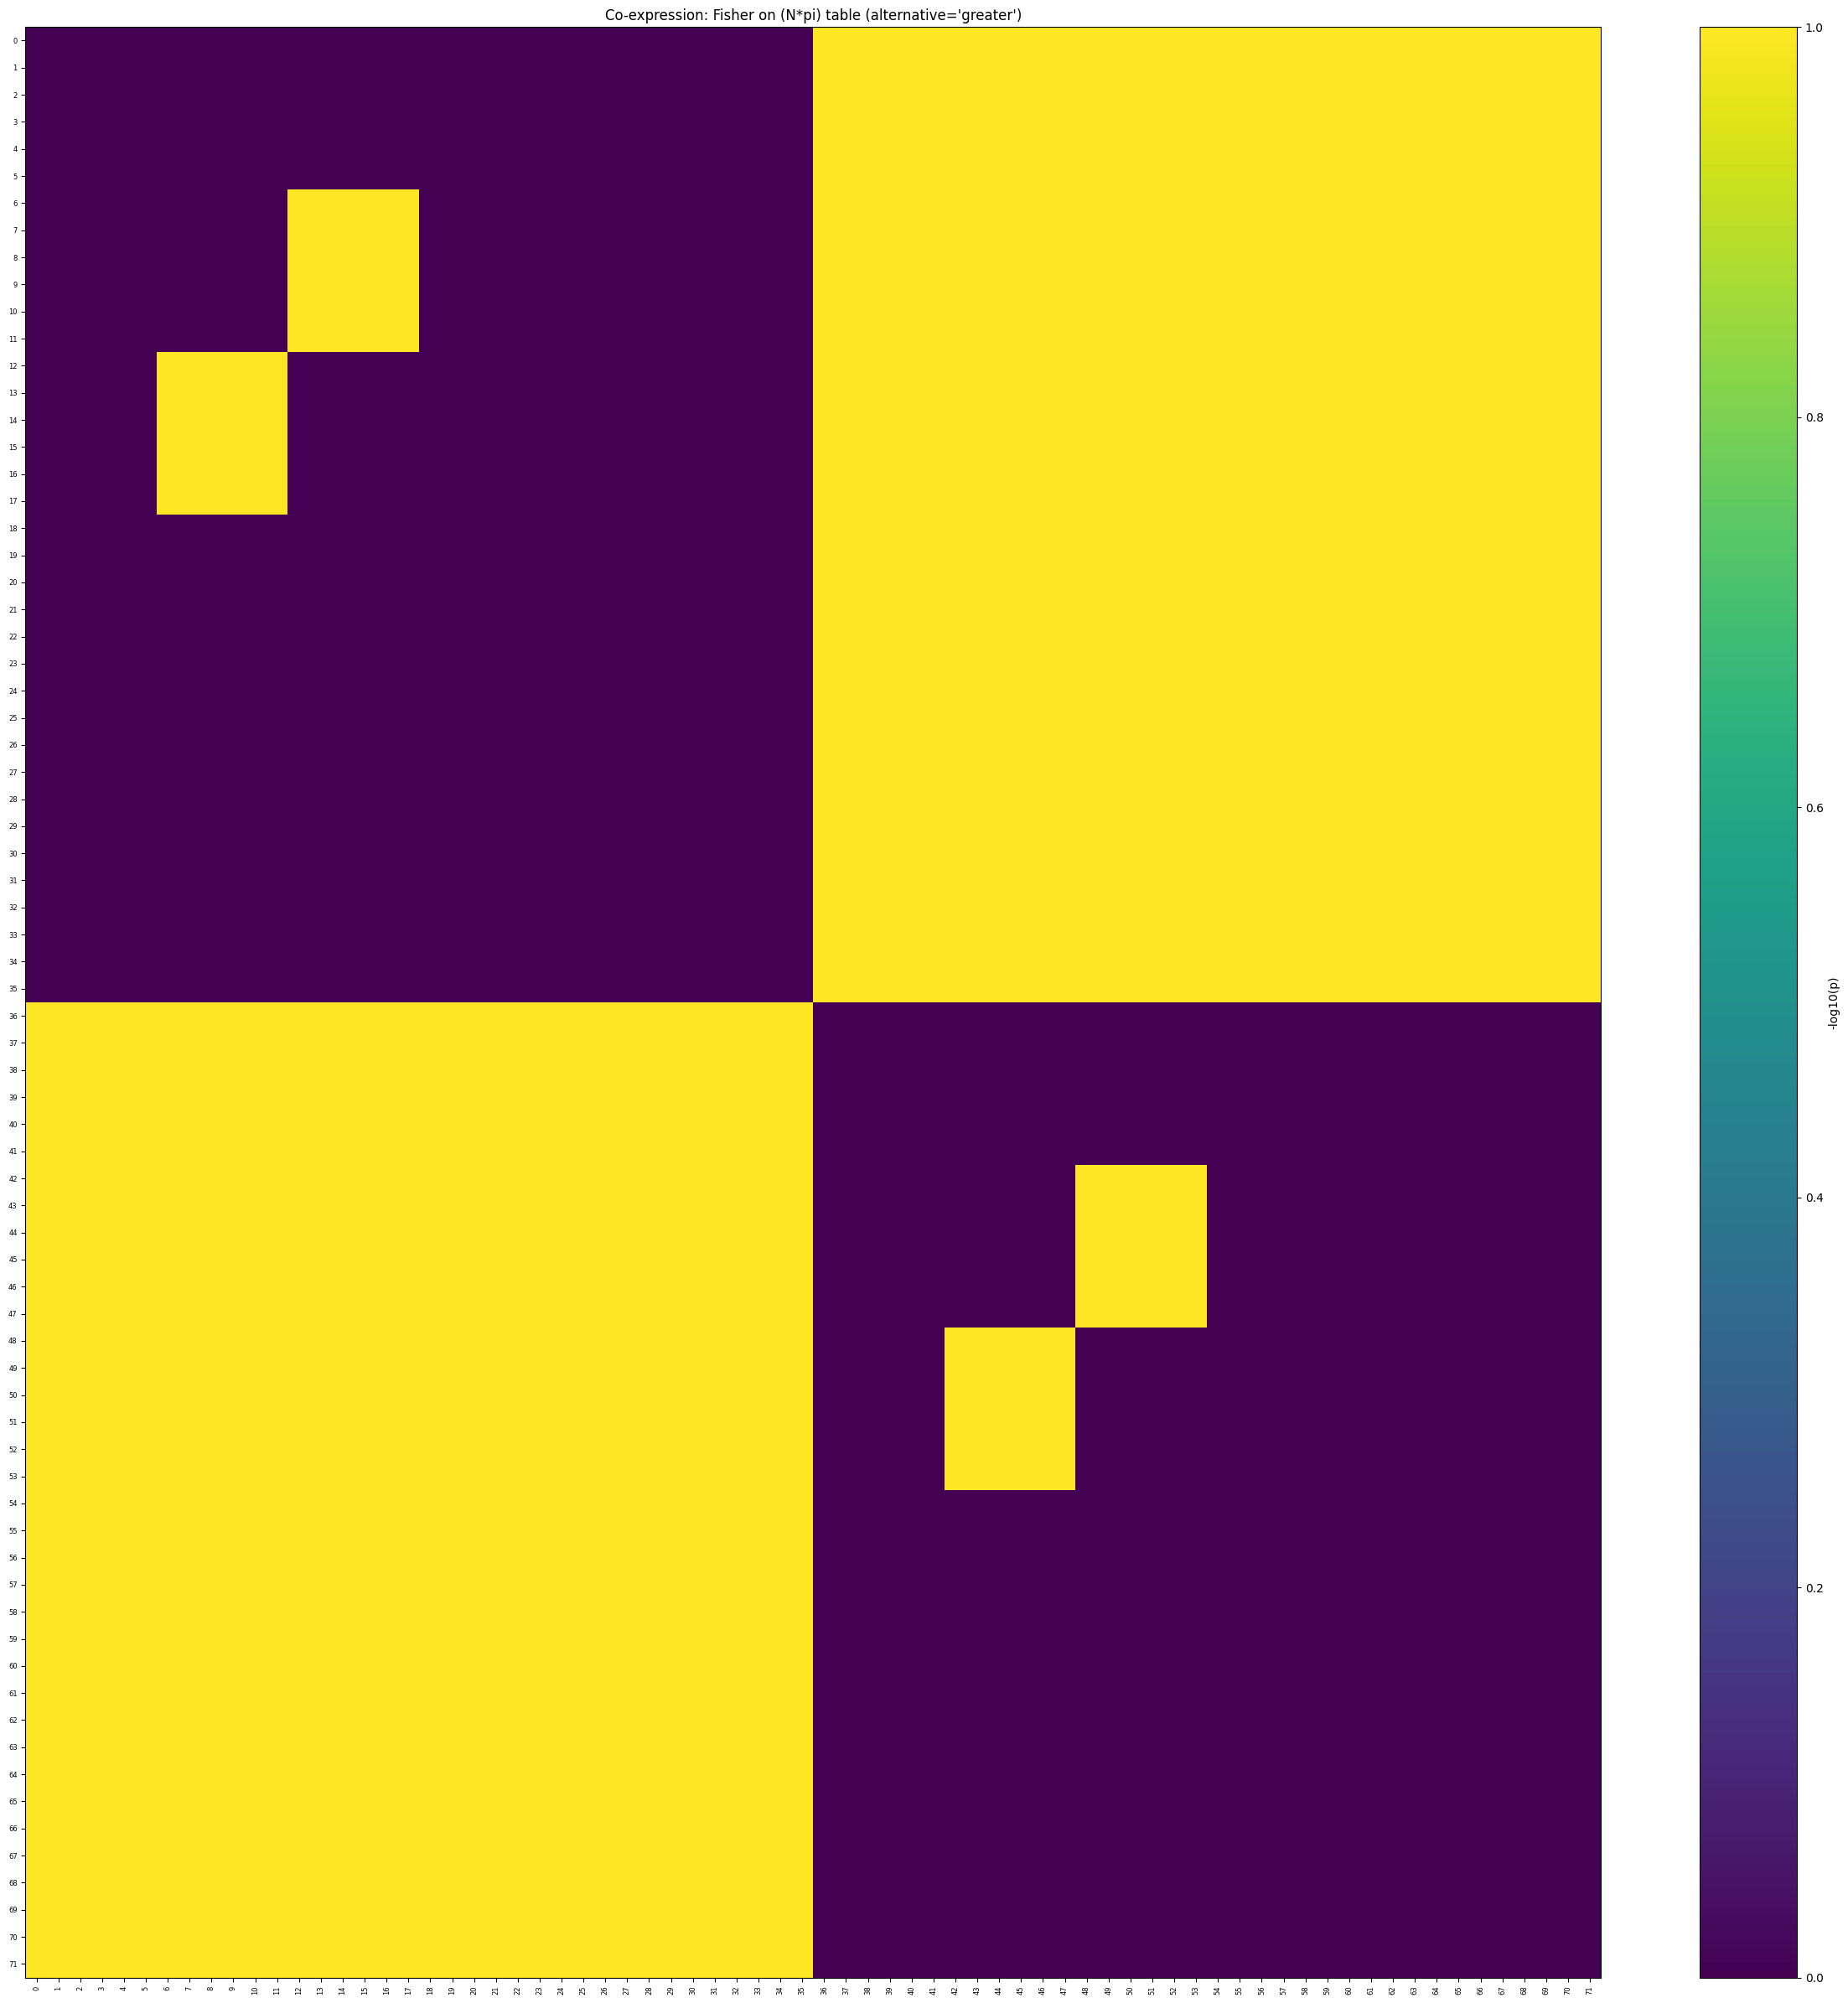

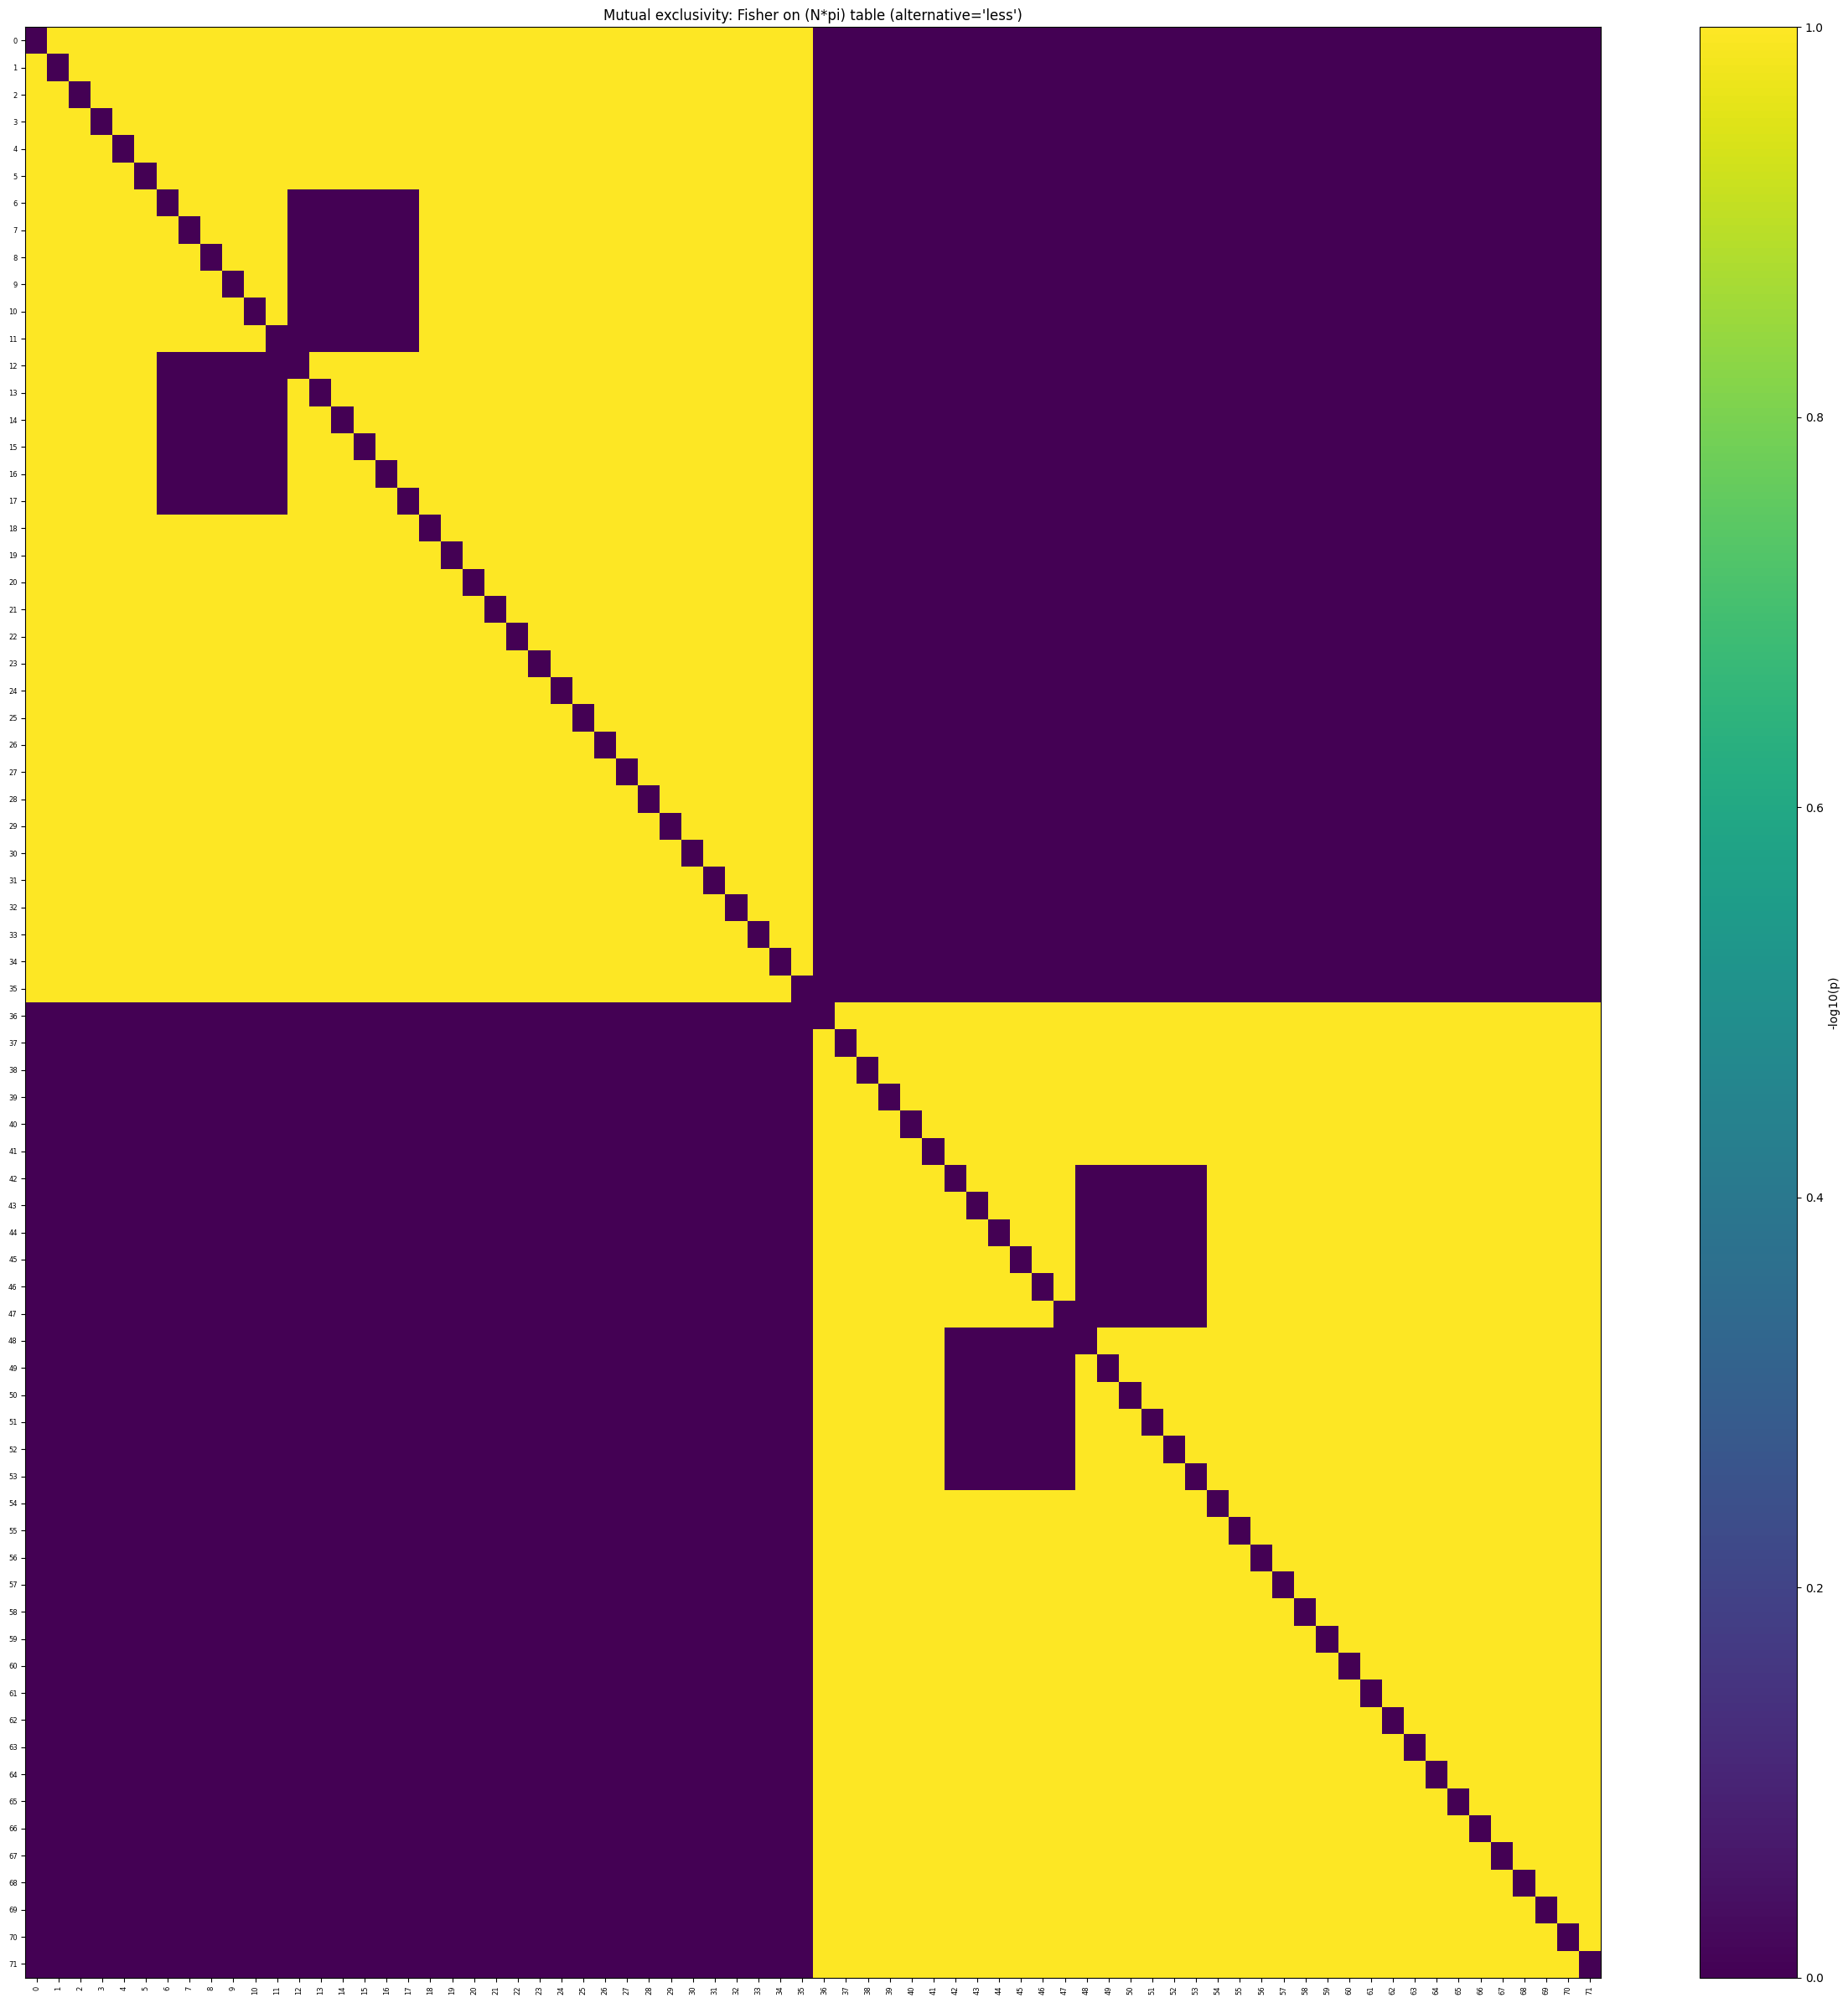

In [13]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

# ========= 0) 选择基因集合：优先 HVG，否则全部 =========
if ("highly_variable" in adata.var.columns) and adata.var["highly_variable"].notna().any():
    genes = adata.var_names[adata.var["highly_variable"].values].tolist()
    print(f"Using highly_variable genes: {len(genes)}")
else:
    genes = adata.var_names.tolist()
    print(f"Using ALL genes: {len(genes)}  (WARNING: may be extremely slow)")

G = len(genes)
N = adata.n_obs

# ========= 1) 准备热图矩阵 =========
heat_co   = np.full((G, G), np.nan, dtype=float)   # -log10(p) for co-expression (greater)
heat_excl = np.full((G, G), np.nan, dtype=float)   # -log10(p) for exclusivity (less)
heat_logOR = np.full((G, G), np.nan, dtype=float)  # log(OR_pi) for direction

clip_p_min = 1e-300  # 避免 p=0 -> inf

# ========= 2) 预取每个基因的表达向量（避免反复切片） =========
Y = {}
for g in genes:
    x = adata[:, g].X   # 如果你想用 layer，比如 counts：改成 adata[:, g].layers["counts"]
    if sp.issparse(x):
        x = x.toarray().reshape(-1)
    else:
        x = np.asarray(x).reshape(-1)
    Y[g] = x

# ========= 3) 双重循环：每对基因拟合 BZINB + Fisher(pis) =========
for i in range(G):
    heat_co[i, i] = 0.0
    heat_excl[i, i] = 0.0
    heat_logOR[i, i] = 0.0

    for j in range(i + 1, G):
        y1 = Y[genes[i]]
        y2 = Y[genes[j]]

        # 3.1 拟合 BZINB 得到 pis = [pi1,pi2,pi3,pi4]
        model = BZINB_Model(tol=1e-4, max_iter=50, lambda_reg=0.2)
        params, pis = model.fit(y1, y2)

        # 3.2 用 pis 构表做 Fisher：共表达 / 互斥
        p_co = fisher_from_bzinb_pis(pis, N, alternative="greater", round_mode="round", seed=0)
        p_ex = fisher_from_bzinb_pis(pis, N, alternative="less",    round_mode="round", seed=0)

        p_co = max(p_co['p_value'], clip_p_min)
        p_ex = max(p_ex['p_value'], clip_p_min)

        heat_co[i, j] = heat_co[j, i] = p_co
        heat_excl[i, j] = heat_excl[j, i] = p_ex
        print(i,j)



# ========= 4) 画两张热图 =========
plt.figure(figsize=(0.25*G + 6, 0.25*G + 6))
plt.imshow(heat_co, aspect="auto")
plt.colorbar(label="-log10(p)")
plt.xticks(np.arange(G), genes, rotation=90, fontsize=6)
plt.yticks(np.arange(G), genes, fontsize=6)
plt.title("Co-expression: Fisher on (N*pi) table (alternative='greater')")
plt.tight_layout()
plt.show()

plt.figure(figsize=(0.25*G + 6, 0.25*G + 6))
plt.imshow(heat_excl, aspect="auto")
plt.colorbar(label="-log10(p)")
plt.xticks(np.arange(G), genes, rotation=90, fontsize=6)
plt.yticks(np.arange(G), genes, fontsize=6)
plt.title("Mutual exclusivity: Fisher on (N*pi) table (alternative='less')")
plt.tight_layout()
plt.show()

# # （可选）方向热图：log(OR_pi)
# plt.figure(figsize=(0.25*G + 6, 0.25*G + 6))
# plt.imshow(heat_logOR, aspect="auto")
# plt.colorbar(label="log(OR_pi)")
# plt.xticks(np.arange(G), genes, rotation=90, fontsize=6)
# plt.yticks(np.arange(G), genes, fontsize=6)
# plt.title("Direction: log(OR_pi) from pis")
# plt.tight_layout()
# plt.show()
